# Gravity Waves

In [1]:
import numpy as np
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

In [2]:
# Parameters
Lx, Lz = 4, 1
Nx, Nz = 256, 64
Rayleigh = 2e6
N2= 1
Prandtl = 1
dealias = 3/2
stop_sim_time = 50
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

In [3]:
# Bases
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(-Lx, Lx), dealias=dealias)
zbasis = d3.RealFourier(coords['z'], size=Nz, bounds=(-Lz, Lz), dealias=dealias)

In [4]:
# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
b = dist.Field(name='b', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
#w = dist.Field(name='w', bases=(xbasis,zbasis))

tau_p = dist.Field(name='tau_p')

In [5]:
x, z = dist.local_grids(xbasis, zbasis)
ex, ez = coords.unit_vector_fields(dist)

In [6]:
grad_u = d3.grad(u) 

In [7]:
problem = d3.IVP([p, b, u, tau_p], namespace=locals())


In [8]:
problem.add_equation("dt(u) + grad(p) - b*ez = 0")
problem.add_equation("div(u) + tau_p = 0")
problem.add_equation("dt(b) + N2*(u@ez) = 0")
problem.add_equation("integ(p) = 0")

{'LHS': Integrate(Integrate(<Field 5187043280>)),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.float64,
 'M': 0,
 'L': Integrate(Integrate(<Field 5187043280>)),
 'F': <Field 5118837840>,
 'domain': <dedalus.core.domain.Domain at 0x1352c8910>,
 'matrix_dependence': array([ True,  True]),
 'matrix_coupling': array([False, False])}

In [9]:
# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2025-02-18 12:58:14,103 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 2s, Rate: 5.2e+01/s
2025-02-18 12:58:14,258 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 7.4e+01/s
2025-02-18 12:58:14,421 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 0s, Remaining: 1s, Rate: 7.7e+01/s
2025-02-18 12:58:14,584 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 1s, Remaining: 1s, Rate: 7.8e+01/s
2025-02-18 12:58:14,743 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 1s, Remaining: 1s, Rate: 7.9e+01/s
2025-02-18 12:58:14,906 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 1s, Remaining: 1s, Rate: 7.9e+01/s
2025-02-18 12:58:15,068 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 1s, Remaining: 1s, Rate: 7.9e+01/s
2025-02-18 12:58:15,231 subsystems 0/1 INFO :: Building subprobl

In [10]:
# Initial conditions
sigma = 0.1
gauss_bump = np.exp(-((x)**2 + (z)**2) / (2 * sigma**2))

#b['g'] *= z * (Lz - z) # Damp noise at walls
#b['g'] += Lz - z # Add linear background
b['g'] = gauss_bump

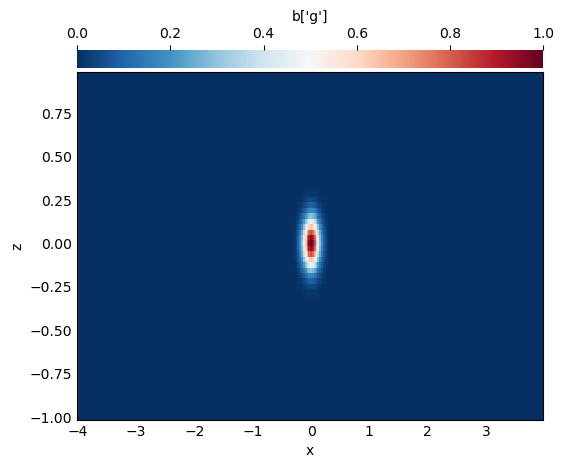

In [11]:
from dedalus.extras.plot_tools import plot_bot_2d
import matplotlib.pyplot as plt
plot_bot_2d(b,title="b['g']");

In [12]:
# Analysis
sim_dt = 0.25
max_writes = stop_sim_time/sim_dt
snapshots = solver.evaluator.add_file_handler('snapshots_IC', sim_dt=sim_dt, max_writes=max_writes)
snapshots.add_task(b, name='buoyancy')
snapshots.add_task(u, name='uvec')
snapshots.add_task(p, name='pressure')
#snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')

In [13]:
# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

In [14]:
# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()


2025-02-18 12:58:16,321 __main__ 0/1 INFO :: Starting main loop
2025-02-18 12:58:17,328 __main__ 0/1 INFO :: Iteration=1, Time=1.250000e-01, dt=1.250000e-01
2025-02-18 12:58:17,507 __main__ 0/1 INFO :: Iteration=11, Time=1.375000e+00, dt=1.250000e-01
2025-02-18 12:58:17,777 __main__ 0/1 INFO :: Iteration=21, Time=2.000000e+00, dt=6.250000e-02
2025-02-18 12:58:18,041 __main__ 0/1 INFO :: Iteration=31, Time=2.312500e+00, dt=3.125000e-02
2025-02-18 12:58:18,296 __main__ 0/1 INFO :: Iteration=41, Time=2.599399e+00, dt=2.868987e-02
2025-02-18 12:58:18,557 __main__ 0/1 INFO :: Iteration=51, Time=2.926708e+00, dt=3.273096e-02
2025-02-18 12:58:18,816 __main__ 0/1 INFO :: Iteration=61, Time=3.346020e+00, dt=4.193113e-02
2025-02-18 12:58:19,075 __main__ 0/1 INFO :: Iteration=71, Time=3.961824e+00, dt=6.158045e-02
2025-02-18 12:58:19,336 __main__ 0/1 INFO :: Iteration=81, Time=4.610595e+00, dt=6.487706e-02
2025-02-18 12:58:19,591 __main__ 0/1 INFO :: Iteration=91, Time=5.155974e+00, dt=5.453796e-

# Check the solution 

In [63]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
import dedalus.public as d3
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [16]:
simdata = './snapshots_IC/snapshots_IC_s1.h5'


In [17]:
with h5py.File(simdata, mode='r') as file:
    a_group_key = list(file.keys())
    print(a_group_key)
    
    print(file['scales'])
    print(list(file['scales']))
    print(file['tasks'])
    print(list(file['tasks']))

['scales', 'tasks']
<HDF5 group "/scales" (9 members)>
['constant', 'iteration', 'sim_time', 'timestep', 'wall_time', 'world_time', 'write_number', 'x_hash_4ed81b13f0aa908bb9caefe50f9a8b6a31597485', 'z_hash_65f3ebdbcb657c9267ce1ace1566dac45ab827ca']
<HDF5 group "/tasks" (3 members)>
['buoyancy', 'pressure', 'uvec']


In [22]:
with h5py.File(simdata, mode='r') as file:
    
    b_data = np.squeeze(np.array(file['tasks']['buoyancy']))
    print('b shape: ' + str(b_data.shape))
    u_data = np.squeeze(np.array(file['tasks']['uvec']))
    print('u_data: ' + str(u_data.shape))
    p_data = np.squeeze(np.array(file['tasks']['pressure']))
    print('p_data: ' + str(p_data.shape))
    #vort_data = np.squeeze(np.array(file['tasks']['vorticity']))
    #div_data = np.squeeze(np.array(file['tasks']['divergence']))
    
    sim_time_ary = np.array(file['scales']['sim_time'])
    print(sim_time_ary)
    
    x = np.array(file['scales'][list(file['scales'])[-2]])
    y = np.array(file['scales'][list(file['scales'])[-1]])
    

b shape: (200, 256, 64)
u_data: (200, 2, 256, 64)
p_data: (200, 256, 64)
[ 0.          0.25        0.5         0.75        1.          1.25
  1.5         1.75        2.          2.25        2.51332908  2.76305347
  3.01057052  3.26215733  3.53076094  3.77708273  4.02670113  4.28620938
  4.54571763  4.77420858  5.0468984   5.29246133  5.51993969  5.79291372
  6.02039208  6.30142303  6.53695832  6.83137742  7.00802889  7.27300608
  7.53798328  7.76709535  8.07257813  8.3016902   8.53252754  8.76336487
  9.05191153  9.28274886  9.54244086  9.80213286 10.06182486 10.32151686
 10.54143912 10.76136138 11.09124477 11.31116702 11.5561344  11.75864376
 12.02865624 12.31228005 12.52840073 12.81656164 13.03268233 13.35686335
 13.57298404 13.78910472 14.08037258 14.2635801  14.53839138 14.81320266
 15.03534207 15.25748148 15.55366735 15.75251297 16.0507814  16.34904983
 16.54789545 16.79789545 17.04789545 17.29789545 17.54789545 17.79789545
 18.04071467 18.28353389 18.52635312 18.80996841 19.01264

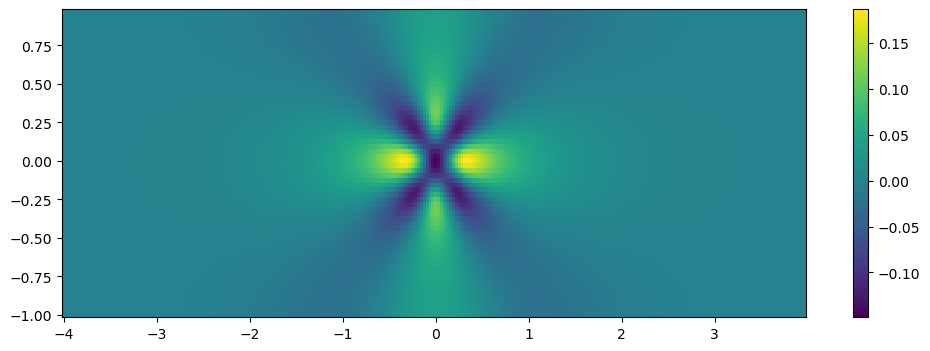

In [24]:
plt.figure(figsize=(12, 4))
plt.pcolormesh(x, y, b_data[20, :,:].T)
plt.colorbar()

In [25]:
def create_animation(fun, idx, filename='my-animation.gif', dpi=200, FPS=18, loop=0):
    '''
    See https://pythonprogramming.altervista.org/png-to-gif/
    fun(i) - a function creating one snapshot, has only one input:
        - number of frame i
    idx - range of frames, i in idx
    FPS - frames per second
    filename - animation name
    dpi - set 300 or so to increase quality
    loop - number of repeats of the gif
    '''
    frames = []
    for i in idx:
        fun(i)
        plt.savefig('.frame.png', dpi=dpi, bbox_inches='tight')
        plt.close()
        frames.append(Image.open('.frame.png').convert('RGB'))
        print(f'Frame {i} is created', end='\r')
    os.system('rm .frame.png')
    # How long to persist one frame in milliseconds to have a desired FPS
    duration = 1000 / FPS
    print(f'Animation at FPS={FPS} will last for {len(idx)/FPS} seconds')
    frames[0].save(
        filename, format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=duration,
        loop=loop)

In [67]:
def plot_fun(time_idx): 
    fig = plt.figure(figsize=(6, 2))
    plt.pcolormesh(x, y, b_data[time_idx, :,:].T, vmin=-0.2, vmax=0.2, cmap='RdBu_r')
    plt.colorbar()
    plt.gca().set_aspect('equal')
    #plt.title(str(sim_time_ary[time_idx])+ ' s')
    plt.title(f"{sim_time_ary[time_idx]:.2f} s")

    plt.tight_layout()
    

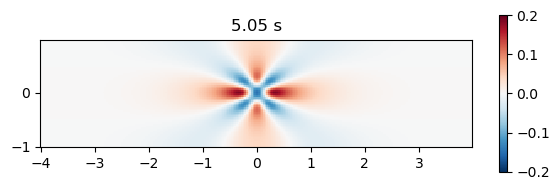

In [68]:
plot_fun(20)

In [69]:
fname = 'GW.gif'
create_animation(plot_fun, range(0, len(sim_time_ary), 1), filename=fname)

Animation at FPS=18 will last for 11.11111111111111 seconds
